## Содержание

- [Импорт библиотек](#destination1)
- [Создание датафрейма для работы](#destination2)
- [Feature engineering (создание объясняющих переменных)](#destination3)
- [Построение моделей](#destination4)
- [Переходим к тестовому датасету](#destination5)

<a id='destination1'></a>
## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold,cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# !pip install catboost
from catboost import CatBoostClassifier
from catboost import Pool
# !pip install lightautoml
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task

import seaborn as sns
import matplotlib.pyplot as plt

'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


C:\Users\bydag\anaconda3\lib\site-packages\lightautoml\ml_algo\dl_model.py:42: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")
C:\Users\bydag\anaconda3\lib\site-packages\lightautoml\text\embed.py:22: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")
C:\Users\bydag\anaconda3\lib\site-packages\lightautoml\text\dl_transformers.py:25: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")


In [58]:
data = pd.read_csv('C:/Users/bydag/Downloads/train.csv')
sub = pd.read_csv('C:/Users/bydag/Downloads/sample_submission.csv')

In [3]:
print(data.head())
print(data.shape)

   user_id   order_completed_at  cart
0        2  2015-03-22 09:25:46   399
1        2  2015-03-22 09:25:46    14
2        2  2015-03-22 09:25:46   198
3        2  2015-03-22 09:25:46    88
4        2  2015-03-22 09:25:46   157
(3123064, 3)


<a id='destination2'></a>
## Создание датафрейма для работы

In [4]:
# Создаем столбец с номером заказа для кажого юзера
data_grouped = data.groupby(['user_id','order_completed_at'],as_index=False).sum()
data_grouped['order_number'] = data.groupby(['user_id','order_completed_at'],as_index=False).cumcount()
data = data.merge(data_grouped, on=['user_id','order_completed_at'],how='left')
data = data.drop('cart_y',axis=1)

Надо создать таргетную переменную, для каждого юзера, входят ли его товары в его последний заказ

In [5]:
# Для этого сначала создаем столбец, где True, если заказ пользователя последний
data['is_max_order_number'] = data.groupby('user_id')['order_number'].transform('max') == data['order_number']

In [6]:
# Создаем столбец, в котором для каждой строки отражается список категорий из последнего заказа пользователя
last_order = data[data['is_max_order_number'] == True]
last_order_grouped = last_order.groupby(['user_id', 'order_number'])['cart_x'].apply(list)

In [7]:
# Джойним к таблице столбец со списками категорий из последних заказов для каждого пользователя
data = data.merge(last_order_grouped, on=['user_id'],how='left')
data.head()

,user_id,order_completed_at,cart_x_x,order_number,is_max_order_number,cart_x_y
0,2,2015-03-22 09:25:46,399,12,False,"[54, 432, 43, 197, 430, 23, 22, 15, 380, 5, 0,..."
1,2,2015-03-22 09:25:46,14,12,False,"[54, 432, 43, 197, 430, 23, 22, 15, 380, 5, 0,..."
2,2,2015-03-22 09:25:46,198,12,False,"[54, 432, 43, 197, 430, 23, 22, 15, 380, 5, 0,..."
3,2,2015-03-22 09:25:46,88,12,False,"[54, 432, 43, 197, 430, 23, 22, 15, 380, 5, 0,..."
4,2,2015-03-22 09:25:46,157,12,False,"[54, 432, 43, 197, 430, 23, 22, 15, 380, 5, 0,..."


In [8]:
#Немного долго, создаем таргетную переменную (принимает значение 1, если категория есть в последнем заказе и ноль, если нет)
data['target'] = data.apply(lambda x: 1 if str(x['cart_x_x']) in str(x['cart_x_y']) else 0, axis=1)

In [9]:
#Оставляем только не последние заказы и дропаем лишние переменные
data_train = data[data['is_max_order_number']==False]
data_train = data_train.drop(['cart_x_y','is_max_order_number'],axis=1)
data_train.head()

,user_id,order_completed_at,cart_x_x,order_number,target
0,2,2015-03-22 09:25:46,399,12,0
1,2,2015-03-22 09:25:46,14,12,0
2,2,2015-03-22 09:25:46,198,12,0
3,2,2015-03-22 09:25:46,88,12,0
4,2,2015-03-22 09:25:46,157,12,0


In [10]:
# Проверяем размер датафрейма
data_train.shape

(2835076, 5)

In [11]:
# Для удобства переименуем переменную категории в ее изначальное название
data_train = data_train.rename(columns={'cart_x_x':'cart'})

<a id='destination3'></a>
## Feature engineering (создание объясняющих переменных)

Теперь из получившегося датасета мы можем создать таблицу, где для таргета будут созданы объясняющие переменные.
Например, можно сделать столбцы со следующей информацией,

относящейся к категориям:
- общее количество заказов с этой категорией,
- популярность категории (можно отранжировать все заказы по популярности и составить рейтинг)

относящейся к пользователям:
- общее количество заказов данного пользователя, 
- средний размер корзины пользователя (сколько всего категорий в заказе)

относящейся к паре пользователь-категория:
- бинарная переменная, является ли товар любимым у пользователя (1 - если да, 0 - нет)
- популярность категории у пользователя (количество заказов с этой категорией по отношению к числу всех его заказов)

In [12]:
#Общее количество заказов с каждой категорией 
total_orders_per_category = data_train.groupby('cart') \
.agg({'order_number':'nunique'}).rename(columns={'order_number':'total_orders_per_category'})

#Популярность категории
popularity = total_orders_per_category.sort_values(by='total_orders_per_category', ascending=False) \
.rank(ascending=False).astype(int) \
.rename(columns={'total_orders_per_category':'popularity'})

#Общее количество заказов каждого пользователя
total_orders_per_user = data_train.groupby('user_id') \
.agg({'order_number':'nunique'}) \
.rename(columns={'order_number':'total_orders_per_user'})

#Размер корзины пользователя
customer_basket_size = data_train \
.groupby(['user_id','order_number'],as_index=False).agg({'cart':'nunique'}) \
.groupby('user_id').agg({'cart':'mean'}) \
.rename(columns={'cart':'customer_basket_size'})

# Создаем переменную, которая хранит в себе самую часто покупаемую категорию для каждого пользователя
favorite = data_train.rename(columns={'cart':'favorite'}).groupby('user_id')['favorite'].apply(lambda x: x.value_counts().idxmax())

#Создаем переменную, которая хранит в себе количество заказов этой категории по отношнию ко всем его заказам
popularity_per_user = (data_train.groupby(['user_id','cart'])['order_number'] \
.count()/data_train.groupby(['user_id'])['order_number'].count()).reset_index() \
.rename(columns={'order_number':'popularity_per_user'})

Теперь присоединим столбцы к тренировочному датафрейму

In [13]:
data_train = data_train.merge(total_orders_per_category, on='cart',how='left')
data_train = data_train.merge(popularity, on='cart',how='left')
data_train = data_train.merge(total_orders_per_user, on='user_id',how='left')
data_train = data_train.merge(customer_basket_size, on='user_id',how='left')
data_train = data_train.merge(favorite, on='user_id',how='left')
data_train = data_train.merge(popularity_per_user, on=['user_id','cart'],how='left')

#После джойна также надо создать колонку, в которой будет 1, если категория является любмой и 0, если нет
data_train['favorite'] = np.where(data_train.cart==data_train.favorite,1,0)

In [14]:
data_train.head()

,user_id,order_completed_at,cart,order_number,target,total_orders_per_category,popularity,total_orders_per_user,customer_basket_size,favorite,popularity_per_user
0,2,2015-03-22 09:25:46,399,12,0,65,99,10,12.9,0,0.006711
1,2,2015-03-22 09:25:46,14,12,0,79,4,10,12.9,0,0.006711
2,2,2015-03-22 09:25:46,198,12,0,70,60,10,12.9,0,0.013423
3,2,2015-03-22 09:25:46,88,12,0,78,6,10,12.9,0,0.013423
4,2,2015-03-22 09:25:46,157,12,0,70,60,10,12.9,0,0.013423


Посмотрим на график корреляции между переменными. Как видим, популярность категории и общее количество заказов с этой категорией абсолютно скоррелированы (что очевидно, так как популярность рассчитывалась на основе второй). Для дальнейшего анализа одну из этих переменных опустим. 

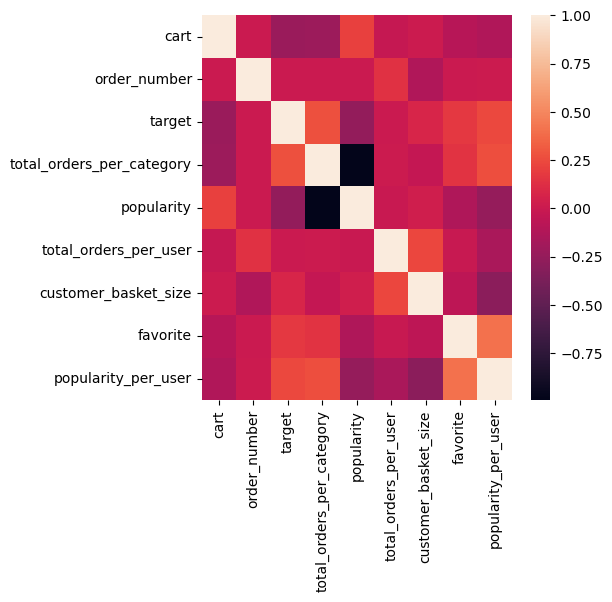

In [15]:
data = data_train.drop(['user_id','order_completed_at'],axis=1)
fig = plt.figure(figsize=(5, 5))
sns.heatmap(data.corr())

plt.show()

Смотрим на рапсределения построенных переменных. Как видим из графиков ниже, у total_orders_per_category распределение визуально ближе к нормальному, чем у переменнной popularity, так что в дальнейший анализ popularity включать не будем.

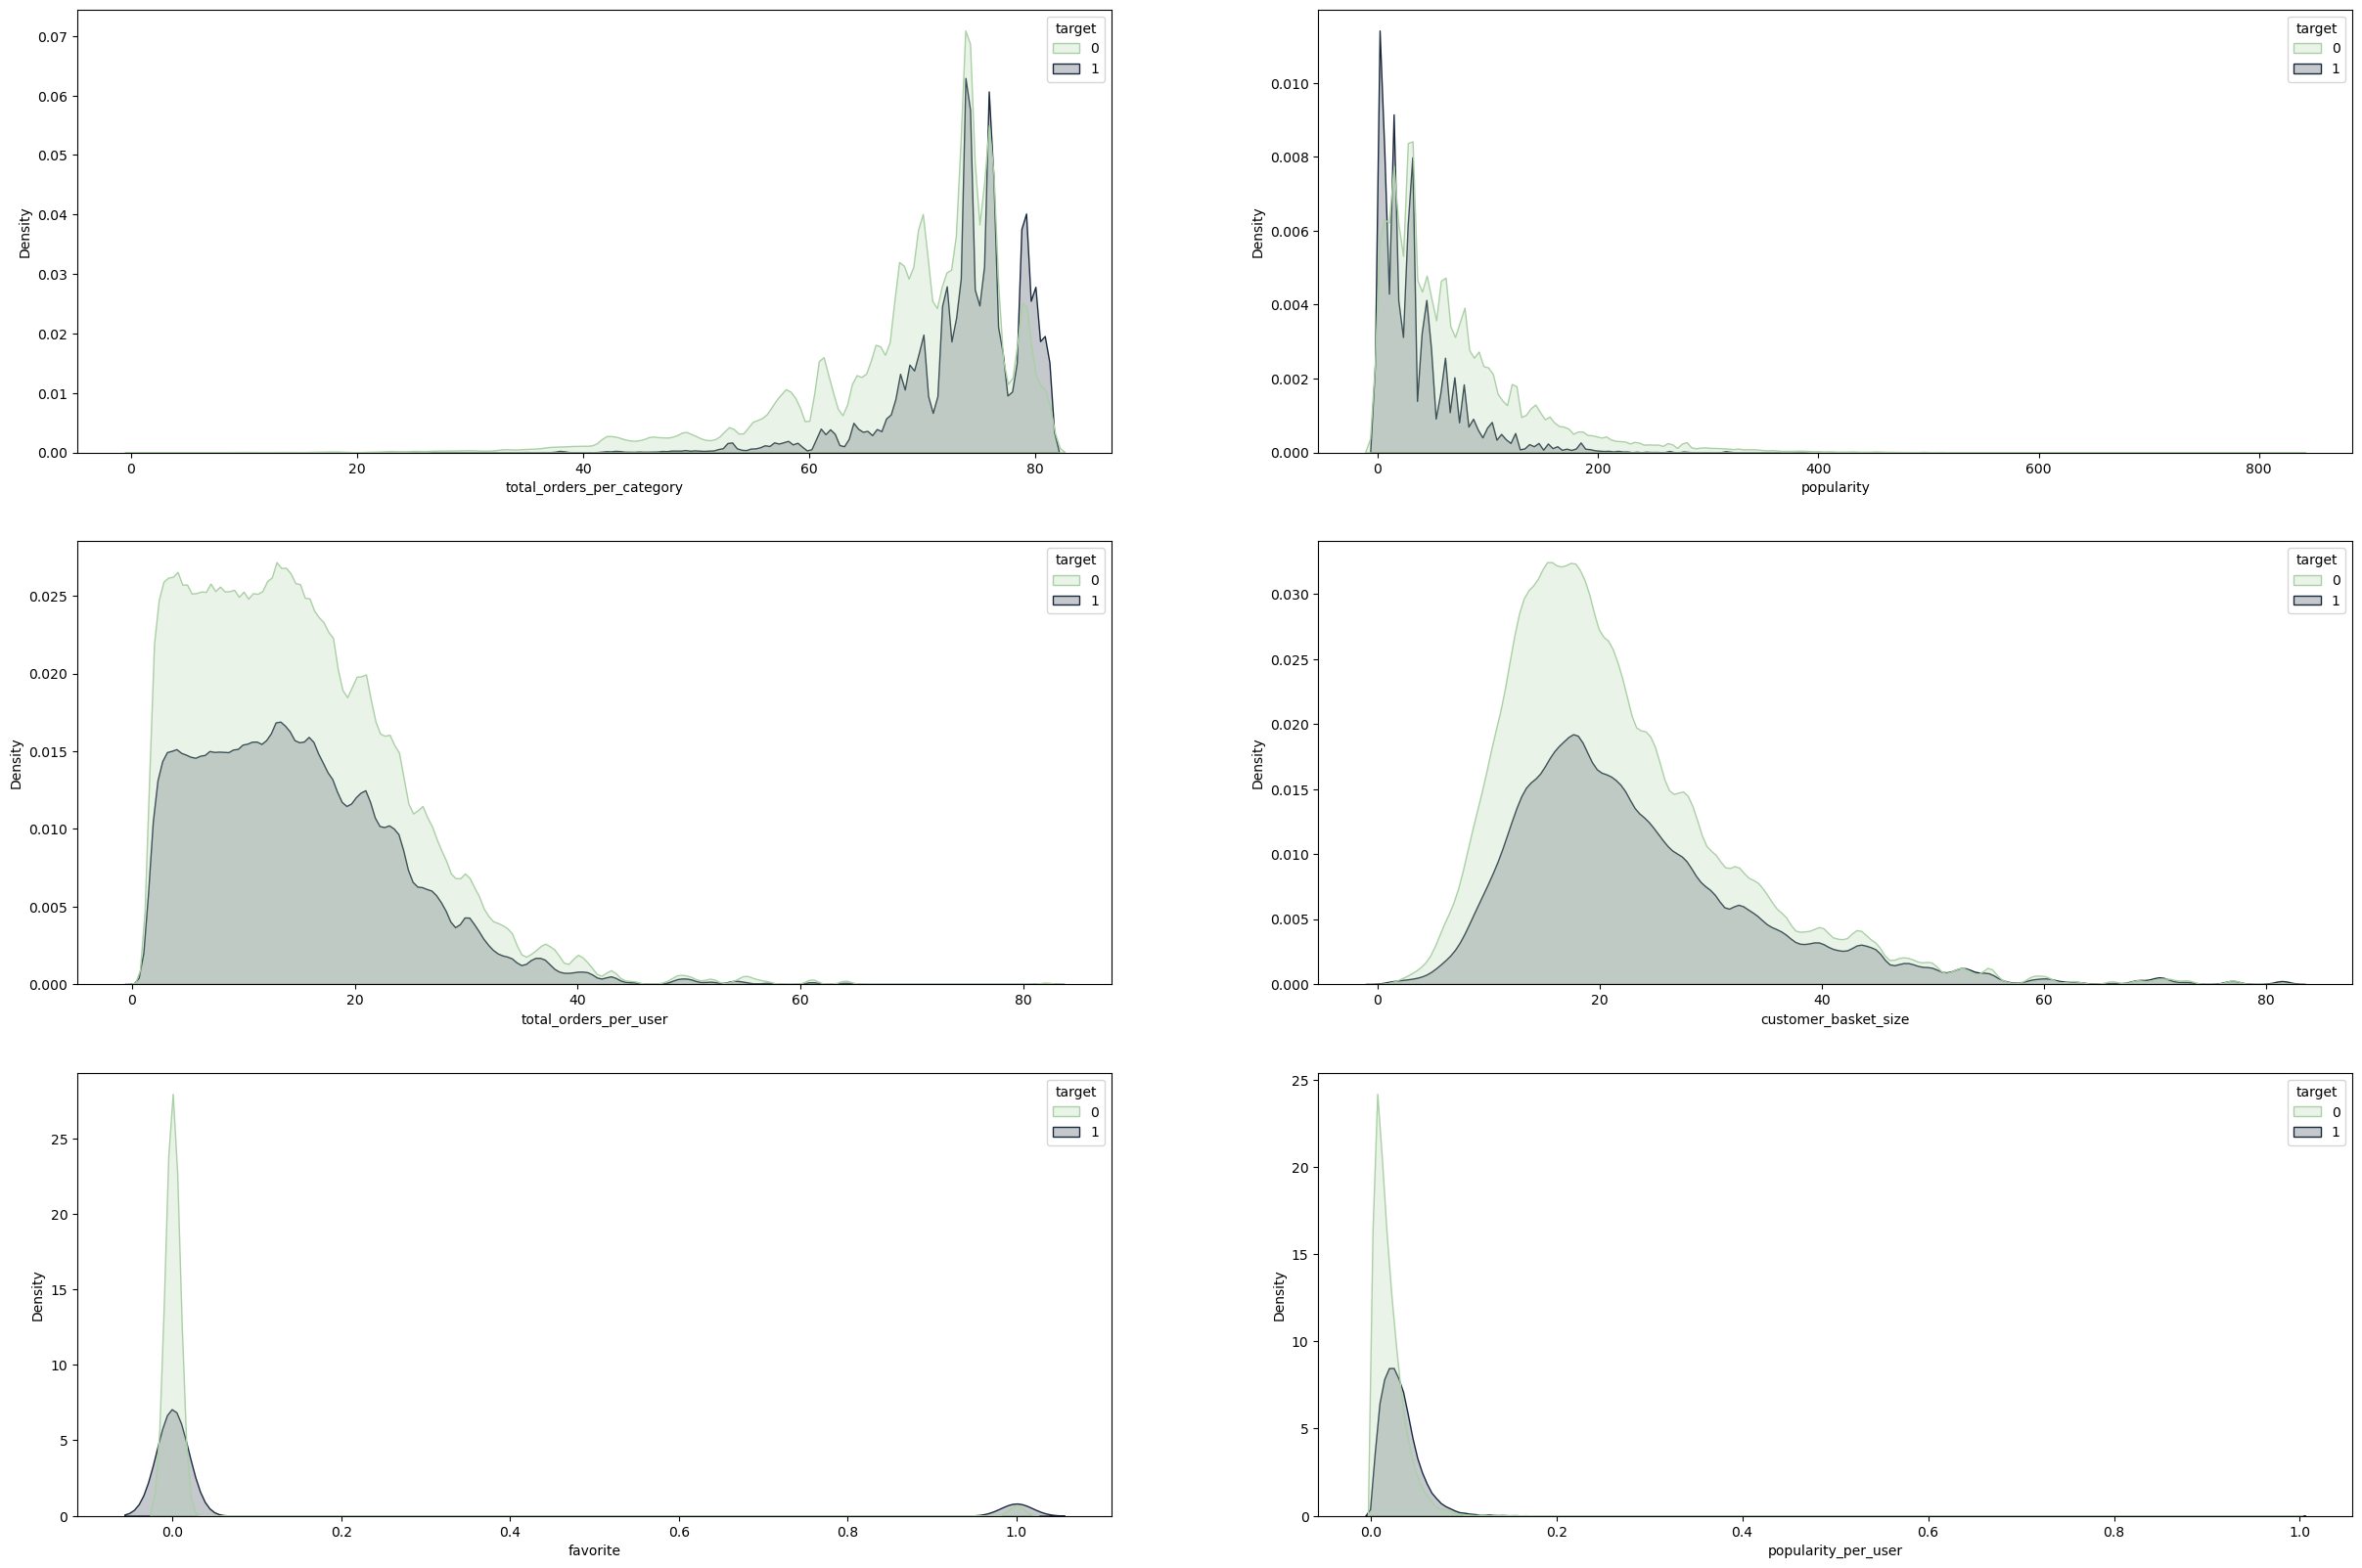

In [16]:
fig, axs = plt.subplots(3, 2, figsize=(30, 20))

sns.kdeplot(data=data_train, x="total_orders_per_category", hue="target", fill=True, palette="ch:r=-.5,l=.75", ax=axs[0,0])
sns.kdeplot(data=data_train, x="popularity", hue="target", fill=True, palette="ch:r=-.5,l=.75", ax=axs[0,1])
sns.kdeplot(data=data_train, x="total_orders_per_user", hue="target", fill=True, palette="ch:r=-.5,l=.75", ax=axs[1,0])
sns.kdeplot(data=data_train, x="customer_basket_size", hue="target", fill=True, palette="ch:r=-.5,l=.75", ax=axs[1,1])
sns.kdeplot(data=data_train, x="favorite", hue="target", fill=True, palette="ch:r=-.5,l=.75", ax=axs[2,0])
sns.kdeplot(data=data_train, x="popularity_per_user", hue="target", fill=True, palette="ch:r=-.5,l=.75", ax=axs[2,1])


plt.show()

<a id='destination4'></a>
## Построение моделей

In [80]:
X = data_train.drop(['order_completed_at','target','user_id','popularity','order_number'],axis=1)
y = data_train.target

In [81]:
# Создадим тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

### Logistic Regression
Начнем с построения логистической регрессии с перебором параметров. По результам оценивания модели видим, что f-1 на тестовых данных равен 0,63. По данным Kaggle этот пока результат оказался наилучшим.

In [82]:
#изначально предположили, что логит может быть чувствительна к масштабированию
#так что переменные были стандартизирвоны, но поскольку результаты оказались хуже, скэлинг убрали
#scal = StandardScaler()

lr = LogisticRegression(random_state=42, class_weight='balanced')
parameters = {'C': (0.00001, 0.0001, 0.001, 0.01, 0.1)}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
lrCV = GridSearchCV(lr,param_grid=parameters,cv=skf,n_jobs=-1,scoring="f1")

#Обучаем модель на всех данных, а не только тренировочных
lrCV.fit(X,y)

predicted = lrCV.predict(X_test)
print(classification_report(y_test,predicted))

C:\Users\bydag\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.79      0.68      0.73    354897
           1       0.57      0.70      0.63    212119

    accuracy                           0.69    567016
   macro avg       0.68      0.69      0.68    567016
weighted avg       0.71      0.69      0.69    567016



Также смотрим на наиболее важные переменные, больше всего влияния оказывает популярность категории для каждого пользователя отдельно.

In [44]:
pd.DataFrame({'name':X.columns,'coef':list(lrCV.best_estimator_.coef_.flatten())}).sort_values('coef',ascending=False)

,name,coef
5,popularity_per_user,0.796484
1,total_orders_per_category,0.497694
3,customer_basket_size,0.413387
4,favorite,0.041386
2,total_orders_per_user,0.008494
0,cart,-0.373483


### Bagging classifier
Теперь перейдем к ансамблевому методу. Результат он выдает такой же, как для модели логистической регрессии.

In [45]:
# bg = BaggingClassifier(lrCV.best_estimator_,max_features=4,n_estimators=100)
# bg.fit(X,y)
# predicted_bg = bg.predict(X_test)
# print(classification_report(y_test,predicted_bg))

### Random Forest
Настройка параметров для леса выполняется слишком долго, поэтому попробуем построить на базовой модели. Результат на Kaggle вышел хуже, чем при использовании логистической регрессии (потому что здесь совсем не были измнены параметры). Так что эту модель оставим.

In [46]:
# rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, class_weight='balanced')
# rf.fit(X,y)

# predicted_rf = rf.predict(X_test)
# print(classification_report(y_test,predicted_rf))

### CatBoost
Хотя на тестовых данных в ноутбуке дает результат, как у логистической регрессии (и лучше), на Kaggle показывает себя хуже, закомментим.

In [47]:
#! pip install catboost

In [48]:
# params = {'verbose':200,'random_seed':42,'learning_rate':0.3}
# model = CatBoostClassifier(**params)

# X.drop('cart',axis=1)
# X_test.drop('cart',axis=1) 

# train_data = Pool(data=X,label=y)
# valid_data = Pool(data=X_test,label=y_test)

# model.fit(train_data,eval_set=valid_data)
# predicted_cat = model.predict(X_test)
# print(classification_report(y_test,predicted_cat))

0:	learn: 0.6163905	test: 0.6165741	best: 0.6165741 (0)	total: 774ms	remaining: 12m 53s
200:	learn: 0.4999074	test: 0.5001655	best: 0.5001655 (200)	total: 2m 42s	remaining: 10m 44s
400:	learn: 0.4878310	test: 0.4880536	best: 0.4880536 (400)	total: 5m 51s	remaining: 8m 45s
600:	learn: 0.4789020	test: 0.4790954	best: 0.4790954 (600)	total: 9m 8s	remaining: 6m 4s
800:	learn: 0.4715097	test: 0.4717034	best: 0.4717034 (800)	total: 11m 55s	remaining: 2m 57s
999:	learn: 0.4648654	test: 0.4649533	best: 0.4649533 (999)	total: 14m 38s	remaining: 0us

bestTest = 0.4649532572
bestIteration = 999

              precision    recall  f1-score   support

           0       0.79      0.88      0.83    354611
           1       0.75      0.61      0.67    212405

    accuracy                           0.78    567016
   macro avg       0.77      0.75      0.75    567016
weighted avg       0.78      0.78      0.77    567016



### Light AutoML
Также попробуем воспользоваться AutoML (идея взята из ноутбука по Титанику: https://www.kaggle.com/code/alexryzhkov/lightautoml-titanic-love/notebook#Step-0.0.-Install-LightAutoML). Использованные модели: Linear model, LightGBM model, LightGBM with tuned params. На Kaggle показала себя плохо, поэтому закомментим.

In [49]:
#!pip install lightautoml
# def f1_metric(y_true, y_pred, **kwargs):
#     return f1_score(y_true, (y_pred > 0.5).astype(int), **kwargs)

# task = Task('binary', metric = f1_metric)
# roles = {
#     'target': 'target',
#     'drop': ['order_completed_at','order_number','user_id'],
# }


# automl = TabularUtilizedAutoML(task = task, 
#                        timeout = 600,
#                        cpu_limit = 4,
#                        general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']]},
#                        reader_params = {'n_jobs': 4})
# oof_pred =  automl.fit_predict(data_train.drop('popularity',axis=1), roles=roles)

In [50]:
# X_test['target'] = y_test
# test_pred = automl.predict(X_test)
# print('TEST score: {}'.format(f1_metric(X_test['target'].values, test_pred.data[:, 0])))

TEST score: 0.7830236572240837


<a id='destination5'></a>
## Переходим к тестовому датасету

In [85]:
# Создаем отдельные колонки для user_id и категории
sub[['user_id', 'cart']] = sub['id'].str.split(';', expand=True).astype('int64')

# Подтягиваем все нужные дополнительные объясняющие переменные
sub = sub.merge(total_orders_per_category, on='cart',how='left')
sub = sub.merge(total_orders_per_user, on='user_id',how='left')
sub = sub.merge(customer_basket_size, on='user_id',how='left')
sub = sub.merge(favorite, on='user_id',how='left')
sub = sub.merge(popularity_per_user, on=['user_id','cart'],how='left')
sub['favorite'] = np.where(sub.cart==sub.favorite,1,0)

# Дропаем ненужные колонки
user_id = sub['user_id']
sub = sub.drop(['target','id','user_id'],axis=1)

#В тестовом датафрейме есть категории, которых не было в тренировочном 
# (категории, которые были заказаны в последнем заказе), так что по этим категориям NA заполняем нулями
sub[sub.isna().any(axis=1)]
sub = sub.fillna(0)

#Предсказываем значения таргета для каждой пары пользователь-категория
sub['target'] = lrCV.predict(sub)

sub['user_id'] = user_id

# Снова создаем переменную пользователь-категория
sub['id'] = sub.user_id.astype(str)+';'+sub.cart.astype(str)

# Дропаем ненужные столбцы
sub.drop(['user_id','cart','total_orders_per_category','total_orders_per_user','customer_basket_size','favorite','popularity_per_user'],axis=1)

# Создаем нужный нам порядок переменных
sub = sub[['id','target']]

# Запсываем результат в csv файл
sub.to_csv('submission_wo_scal.csv', index = False)

In [63]:
sub.head()

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,0
4,0;14,1
